In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../../data/')

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler
import torch.optim as optim

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, get_indices, get_hard_label, collate_fn
from loss import LBPloss
from visualize import visualize

from tqdm import tqdm
from resnet import resnet18, resnet12
# from model import ClassificationModel

In [2]:
df = pd.read_csv('../../data/df.csv')
print(df.shape)
df.head()

(3234, 11)


,file_name,task,bbox,xmin,ymin,w,h,label,occluded,des,cell_type
0,patch_images/2021.01.12/LBC305-20210108(1)/LBC...,[ASCUS] LBC305,"[56, 35, 1980, 1985]",56,35,1980,1985,판독불가,0,NaN,NaN
1,patch_images/2021.01.12/LBC305-20210108(1)/LBC...,[ASCUS] LBC305,"[56, 30, 1912, 1937]",56,30,1912,1937,판독불가,0,NaN,NaN
2,patch_images/2021.01.12/LBC305-20210108(1)/LBC...,[ASCUS] LBC305,"[21, 12, 2010, 2027]",21,12,2010,2027,판독불가,0,NaN,NaN
3,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[1349, 420, 100, 113]",1349,420,100,113,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...
4,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[1575, 720, 163, 213]",1575,720,163,213,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...


In [3]:
df.label.value_counts()

ASC-US                       1195
ASC-US with HPV infection     515
AS                            461
LSIL                          316
C                             290
LSIL with HPV infection        84
HS                             76
ASC-H                          70
HSIL                           68
LS                             50
Benign atypia                  46
AH                             36
Carcinoma                      18
판독불가                            4
Negative                        3
ASCUS-SIL                       2
Name: label, dtype: int64

In [4]:
df['label_id'] = df.label.apply(lambda x : 1.0 if ('ASC-US' in str(x) ) or ('AS' == str(x)) else 0.)
df = df[df['label_id'] == 1.]
df.shape

(2171, 12)

In [5]:

# df['label_id'] = df.label.apply( lambda x : 0.)
df_data = df.groupby('file_name')
def get_data(img_id):
    if img_id not in df_data.groups:
        return dict(image_id=img_id, boxes=list())
    
    data  = df_data.get_group(img_id)
#     boxes = data['bbox'].values
    boxes = data[['xmin', 'ymin', 'w', 'h', 'label_id']].values
#     labels = data['label'].values
    return dict(image_id = img_id, boxes = boxes)
#     return dict(image_id = img_id, boxes = boxes, labels=labels)

train_list = [get_data(img_id) for img_id in df.file_name.unique()]
print(len(train_list))
# df.head()

train_list[0]

1781


{'image_id': 'patch_images/2021.01.06/LBC37-20210102(1)/LBC37-20210102(1)_1016.png',
 'boxes': array([[1.349e+03, 4.200e+02, 1.000e+02, 1.130e+02, 1.000e+00]])}

In [6]:
path = '/home/Dataset/scl/patch_images/2021.01.06/LBC24-20210102(1)/'
file_list = ['patch_images/2021.01.06/LBC24-20210102(1)/' + d for d in os.listdir(path)]
file_list[:2]


test_list = [get_data(img_id) for img_id in file_list]
test_list[:2]

[{'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1160.png',
  'boxes': []},
 {'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1817.png',
  'boxes': []}]

In [7]:
BATCH_SIZE = 8
STRIDE = 32
KERNEL_SIZE = 128
train_dataset = LbpDataset(
    train_list,
    transform=train_transforms,
    stride=STRIDE,
    kernel_size=KERNEL_SIZE
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=8,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn
)

test_dataset = LbpDataset(
    test_list,
    transform=val_transforms,
    stride=STRIDE,
    kernel_size=KERNEL_SIZE    
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn
)

In [8]:
examples = next(iter(train_loader))
images, cell_iou, targets, path, boxes = examples
print(type(images))
# print(np.concatenate(images, axis=0).shape)
print(boxes)
# boxes = np.array(boxes)
# boxes[:,2] = boxes[:,2] + boxes[:,0]
# boxes[:,3] = boxes[:,1] + boxes[:,3]
# visualize(image.squeeze().numpy(), boxes[:,:4])

<class 'tuple'>
([(1444.8435094920471, 413.09382839939786, 243.7845048742945, 183.93978926241851, 1.0), (1270.411493073371, 1167.3497240341194, 168.1272447408926, 172.63622679377818, 1.0)], [(871.0, 1187.0, 134.0, 113.0, 1.0)], [(523.1957333333334, 1745.3745704467353, 172.5781333333333, 147.79381443298985, 1.0)], [(201.0, 1222.0, 108.0, 124.0, 1.0)], [(502.0, 1347.0, 145.0, 163.0, 1.0)], [(469.0, 1244.0, 90.0, 87.0, 1.0)], [(308.0, 1306.0, 158.0, 150.0, 1.0)], [(211.36673346693388, 1166.2222222222222, 169.29859719438875, 130.63374485596705, 1.0)])


In [10]:
(images[1].shape)
# type(images[1] < 0.9)
cell_iou[0].shape
# torch.where(cell_iou[IMAGE_NUM].view(grid_size,grid_size) >= 0.5)

torch.Size([4096, 1])

In [ ]:
plt.figure(figsize=(5, 10))
# plt.imshow((images[1] < 0.9).float())
grid_size

In [11]:
IMAGE_NUM=1
STRIDE = 32
KERNEL_SIZE = STRIDE * 4
kernel_size = KERNEL_SIZE
stride = STRIDE
# grid_size = 1 + int((images.shape[1]- kernel_size) / stride )
grid_size = 1 + int((images[IMAGE_NUM].shape[1]- kernel_size) / stride )
print('k_size {} stride {} grid size {}'.format(kernel_size, stride, grid_size))
# row, col = (cell_iou.view(8,64,64)[IMAGE_NUM] > 0.6).nonzero(as_tuple=True)
row, col = torch.where(cell_iou[IMAGE_NUM].view(grid_size,grid_size) >= 0.5)
# row, col = torch.where(cell_iou.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] < 0.1)
# row, col = torch.where((cell_iou.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]>0.1)&(cell_iou.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]<0.8))
bboxes = []

for x, y in zip(col, row) :
#     print(int(x), int(y))
    xmin = int(x) * stride
    xmax = xmin + kernel_size
    ymin = int(y) * stride
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
# print(len(bboxes))

# visualize(images[IMAGE_NUM].permute(2,1,0).cpu().detach().numpy(), bboxes)
visualize(images[IMAGE_NUM], bboxes)

k_size 128 stride 32 grid size 61


RuntimeError: shape '[61, 61]' is invalid for input of size 4096

In [23]:
# plt.hist(cell_iou.numpy().ravel(), bins=20)

AttributeError: 'tuple' object has no attribute 'numpy'

In [24]:
path

('patch_images/2021.01.06/LBC32-20210102(1)/LBC32-20210102(1)_1491.png',
 'patch_images/2021.01.07/LBC77-20210104(1)/LBC77-20210104(1)_1987.png',
 'patch_images/2021.01.11/LBC199-20210106(1)/LBC199-20210106(1)_780.png',
 'patch_images/2021.01.06/LBC37-20210102(1)/LBC37-20210102(1)_516.png',
 'patch_images/2021.01.11/LBC199-20210106(1)/LBC199-20210106(1)_1364.png',
 'patch_images/2021.01.12/LBC308-20210108(1)/LBC308-20210108(1)_1873.png',
 'patch_images/2021.01.06/LBC26-20210102(1)/LBC26-20210102(1)_778.png',
 'patch_images/2021.01.15/LBC521-20210112(1)/LBC521-20210112(1)_1067.png')

In [13]:
# images, cell_iou, targets, path = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 2048, 3)


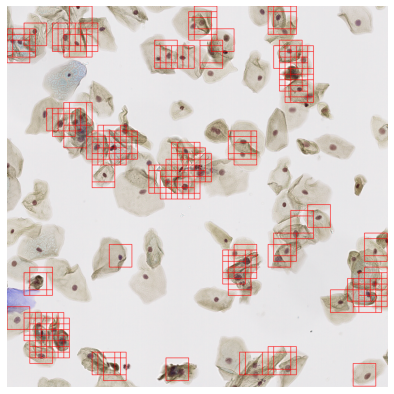

In [27]:
IMAGE_NUM=0
# row, col = (cell_iou.view(8,64,64)[IMAGE_NUM] > 0.6).nonzero(as_tuple=True)

row, col = torch.where(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] >= 0.9)
# row, col = torch.where((targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]<0.5)&(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]>0.))
bboxes = []

kernel_size = KERNEL_SIZE
stride = STRIDE
for x, y in zip(col, row) :
#     print(int(x), int(y))
    xmin = int(x) * stride
    xmax = xmin + kernel_size
    ymin = int(y) * stride
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
# print(len(bboxes))

# visualize(images[IMAGE_NUMpath].permute(2,1,0).cpu().detach().numpy(), bboxes)
visualize(images[IMAGE_NUM].numpy(), bboxes)

<class 'numpy.ndarray'>
[[564. 641. 248. 203.   1.]]
(2048, 2048, 3)


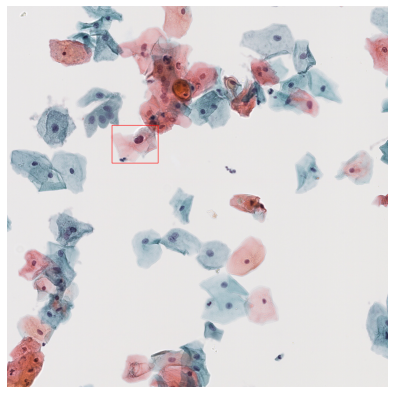

In [18]:
img_path = path[IMAGE_NUM]
abs_path = '/home/Dataset/scl/'

train_image = cv2.imread(abs_path + img_path)
print(type(train_image))
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
boxes = get_data(img_path)['boxes']
print(boxes)
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

visualize(train_image, boxes[:,:4])

In [28]:
iou, targets = get_hard_label(cell_iou, targets)
print(targets.shape)

TypeError: 'tuple' object does not support item assignment

torch.Size([32768, 1])

In [17]:
#     batch_targets = []
#     for i in range(8) :
#         abnormal_cell_not = torch.where((targets[i,:,0] == 0.))[0]
#         abnormal_cell_not_indices = torch.randperm(len(abnormal_cell_not))[10:]   

#         abcell_not = (abnormal_cell_not[abnormal_cell_not_indices])  
#         print(abcell_not)
#         print(len(abcell_not))
#         targets[i,abcell_not,:] = -1. 
#         batch_targets.append(targets)
    
# #     torch.stack(batch_targets).shape
#     targets.shape

In [18]:
len(torch.where((targets[:,:,0] == 0.))[0])

80

In [19]:
(targets == 1.).sum()

tensor(14)

In [20]:
targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM].shape

torch.Size([64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 2048, 3)


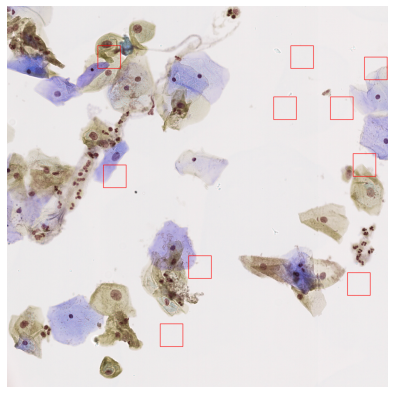

In [21]:
# IMAGE_NUM=4
# row, col = (cell_iou.view(8,64,64)[IMAGE_NUM] > 0.6).nonzero(as_tuple=True)
# images, cell_iou, targets, path = next(iter(train_loader))
row, col = torch.where(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] == 0.)
# row, col = torch.where((targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]<0.5)&(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM]>0.))
bboxes = []

kernel_size = KERNEL_SIZE
stride = STRIDE
for x, y in zip(col, row) :
#     print(int(x), int(y))
    xmin = int(x) * stride
    xmax = xmin + kernel_size
    ymin = int(y) * stride
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
# print(len(bboxes))

# visualize(images[IMAGE_NUMpath].permute(2,1,0).cpu().detach().numpy(), bboxes)
visualize(images[IMAGE_NUM].numpy(), bboxes)

In [22]:

# torch.where(cell_iou.view(8,64,64)[0] > 0.7)

In [23]:
device = torch.device('cuda')
# model = CNNModel().to(device)
model = resnet12(pretrained=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4 )
loss_fn = LBPloss(device).to(device)
scaler = torch.cuda.amp.GradScaler()

In [24]:
# saved_model = '../trained_models/model_v1.pt'
# model.load_state_dict(torch.load(saved_model))

In [25]:
epochs = 10
init_loss = 1.
saved_model = '../trained_models/resnet/model.pt'

for epoch in (range(epochs)) :
    batch_losses = []
    loop = tqdm(train_loader, leave=True)
    model.train()
    for images, iou, targets, path in loop :

        batch_size, grid_len, _ = iou.shape
        images = images.permute(0,3,1,2).to(device)

#         indices, iou, targets = get_indices(iou, targets)
        iou, targets = get_hard_label(iou, targets)
        labels = torch.cat([iou, targets], dim=-1)
        labels = labels.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(images, indices=None)
#             print(outputs.shape)
            outputs = outputs.permute(0,2,3,1).view(batch_size, grid_len, -1)
                 
            loss, ab_loss, num_ab = loss_fn(outputs, labels)

        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1./(epochs+1))
        scaler.step(optimizer)
        scaler.update()
        
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
#         optimizer.step()
        batch_losses.append(loss.item())

        mean_loss = sum(batch_losses) / len(batch_losses)
            
        loop.set_postfix(total_loss=mean_loss, ab_loss=ab_loss.item(), num_ab=num_ab.item()) 
    if mean_loss < init_loss :
        init_loss = mean_loss
        torch.save(model.state_dict(), saved_model)
        print('model is saved')        


  0%|          | 0/222 [00:00<?, ?it/s]

model is saved


  0%|          | 0/222 [00:00<?, ?it/s]

model is saved


 22%|██▏       | 48/222 [01:07<04:03,  1.40s/it, ab_loss=0, num_ab=0, total_loss=0.0306]
Traceback (most recent call last):
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7

KeyboardInterrupt: 

In [26]:
saved_model = '../trained_models/resnet/model_v1.pt'
torch.save(model.state_dict(), saved_model)
# saved_model = '../trained_models/model_v1.pt'



In [27]:
saved_model = '../trained_models/resnet/model_v1.pt'
device = torch.device('cuda')
model = resnet12(pretrained=False).to(device)
model.load_state_dict(torch.load(saved_model))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
images, cell_iou, targets , path = next(iter(train_loader))
# images, cell_iou, targets , path = next(iter(test_loader))
print(images.shape)
batch_size, seq_len, _ = cell_iou.shape
images = images.permute(0,3,1,2).to(device)
with torch.no_grad():
    outputs = model(images, indices=None)

torch.Size([8, 2048, 2048, 3])


In [32]:
kernel_size = KERNEL_SIZE
stride = STRIDE
# grid_size = 1 + int((images.shape[1]- kernel_size) / stride )
grid_size = 64

NUM_Class = 3
print((outputs.permute(0,2,3,1)[1,:,:,0] > 0.4).sum() )
# print((outputs.view(BATCH_SIZE,grid_size,grid_size,NUM_Class)[1,:,:,0] > 0.9).sum() )
# print((outputs.view(BATCH_SIZE,grid_size,grid_size,NUM_Class)[1,:,:,1] > 0.9).sum() )
# print(torch.max(outputs.view(BATCH_SIZE,grid_size,grid_size,NUM_Class)[0,:,:,1]))
# print(torch.max(outputs.view(BATCH_SIZE,grid_size,grid_size,NUM_Class)[1,:,:,1]))
# print(torch.max(outputs.view(BATCH_SIZE,grid_size,grid_size,NUM_Class)[2,:,:,1]))

tensor(0, device='cuda:0')


In [33]:
grid_size

64

tensor(0.2418)
0
(2048, 2048, 3)


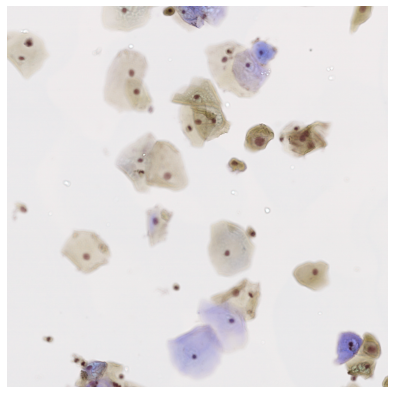

In [35]:
# image with prediction
IMAGE_NUM=0
maxi = torch.max((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
print(maxi)
row, col = ((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0]) > 0.63).cpu().detach().nonzero(as_tuple=True)
bboxes = []

for x, y in zip(row, col) :
    xmin = int(x) * stride
    xmax = xmin + kernel_size
    ymin = int(y) * stride
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
print(len(bboxes))

visualize(images[IMAGE_NUM].permute(2,1,0).cpu().detach().numpy(), bboxes)

<class 'numpy.ndarray'>
(2048, 2048, 3)


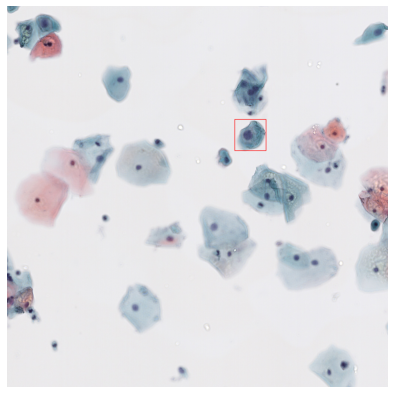

In [36]:
# image with annotation
img_path = path[IMAGE_NUM]
abs_path = '/home/Dataset/scl/'
train_image = cv2.imread(abs_path + img_path)
print(type(train_image))
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
boxes = get_data(img_path)['boxes']
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

visualize(train_image, boxes[:,:4])